<a href="https://colab.research.google.com/github/smorenorod/Python-Codes/blob/main/LTV_scenarios_POD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
#import pygsheets
from google.colab import auth
import gspread
from google.auth import default
import ipywidgets as widgets
from datetime import date, timedelta, datetime
import json

#retention data

In [ ]:
#define GO URL

ret_go_url='https://api.sensortower.com/v1/android/usage/retention?app_ids=com.habby.punball,com.habby.archero\
&date_granularity=all_time&start_date=2021-01-01&end_date=2021-04-01&auth_token=yourtoken'


#define iOS URL

ret_ios_url='https://api.sensortower.com/v1/ios/usage/retention?app_ids=1453651052,1585781366&date_granularity=all_time\
&start_date=2021-01-01&end_date=2021-04-01&auth_token=yourtoken'




In [ ]:
#requesting go data
response_API_go = requests.get(ret_go_url)

#requesting ios data
response_API_ios = requests.get(ret_ios_url)

In [ ]:
#test API connection (code 200 means connection is OK)
print(response_API_go.status_code)

200


In [ ]:
#get data
content = json.loads(response_API_go.content)

df_prov = pd.DataFrame.from_dict(content['app_data'])
ret=df_prov.loc[:,'corrected_retention']

ret_go=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
ret_go.columns = list(df_prov['app_id'])

ret_go.columns = ['Archero', 'PunBall']

ret_go

,Archero,PunBall
0,0.587719,0.585327
1,0.493640,0.513243
2,0.420782,0.455719
3,0.366968,0.412066
4,0.327380,0.378302
...,...,...
85,0.044583,0.056924
86,0.043963,0.057151
87,0.043339,0.057447
88,0.042810,0.057638


In [ ]:
#get data
content = json.loads(response_API_ios.content)

df_prov = pd.DataFrame.from_dict(content['app_data'])
ret=df_prov.loc[:,'corrected_retention']

ret_ios=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
ret_ios.columns = list(df_prov['app_id'])

ret_ios.columns = ['Archero', 'PunBall']

ret_ios

,Archero,PunBall
0,0.603849,0.586637
1,0.514448,0.509625
2,0.443469,0.450776
3,0.389576,0.408265
4,0.349022,0.376866
...,...,...
85,0.050443,0.054296
86,0.049877,0.053986
87,0.049290,0.053675
88,0.048752,0.053365


In [ ]:
#iOS and Android Mixture


# initialize list of lists
data = [['Archero', 0.522, 0.478], ['PunBall', 0.699, 0.301]]

# Create the pandas DataFrame
mixture = pd.DataFrame(data, columns=['Game', 'Android','iOS'])


mixture



,Game,Android,iOS
0,Archero,0.522,0.478
1,PunBall,0.699,0.301


In [ ]:
#Unified retention

ret_unif=pd.DataFrame(columns=['Archero', 'PunBall'])


ret_unif['Archero']=ret_go['Archero']*mixture.iloc[0,1]+ret_ios['Archero']*mixture.iloc[0,2]

ret_unif['PunBall']=ret_go['PunBall']*mixture.iloc[1,1]+ret_ios['PunBall']*mixture.iloc[1,2]

ret_unif

,Archero,PunBall
0,0.595429,0.585721
1,0.503586,0.512154
2,0.431626,0.454231
3,0.377775,0.410922
4,0.337725,0.377870
...,...,...
85,0.047384,0.056133
86,0.046790,0.056198
87,0.046184,0.056312
88,0.045650,0.056352


In [ ]:
#
ret_unif['Day']=pd.date_range('2022-04-09', periods=90, freq='D')

ret_unif.set_index('Day', inplace=True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt


#https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861

# Archero Forecast and Trend Extrac

In [ ]:
model_holt = Holt(ret_unif['Archero'], damped_trend=True).fit(optimized=True)
forecasts_holt_arc = model_holt.forecast(90)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<ipython-input-164-3fd2a4bf0c70>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Archero=Archero.append(pd.DataFrame(forecasts_holt_arc,columns=['Archero']))


<Axes: >

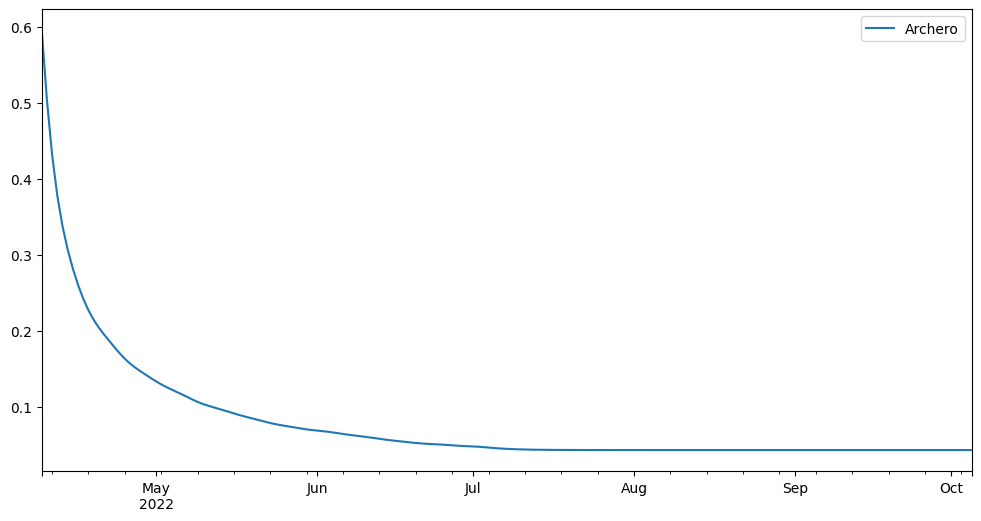

In [ ]:

Archero=ret_unif[['Archero']]

Archero=Archero.append(pd.DataFrame(forecasts_holt_arc,columns=['Archero']))
Archero.plot( y='Archero', figsize=(12,6))

In [ ]:
analysis_arc = Archero.copy()

decompose_result_mult_arc = seasonal_decompose(analysis_arc, model="multiplicative",two_sided=True,extrapolate_trend=3)

trend_arc = decompose_result_mult_arc.trend
seasonal_arc = decompose_result_mult_arc.seasonal
residual_arc = decompose_result_mult_arc.resid


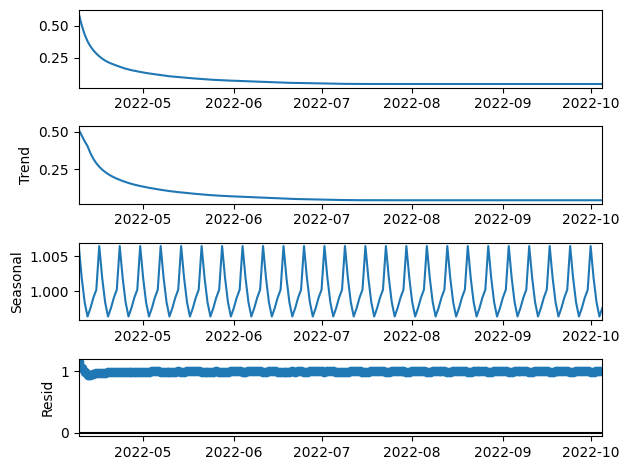

In [ ]:
decompose_result_mult_arc.plot();

In [ ]:

with open('csv','w') as f:
  f.write(pd.concat([trend_arc,seasonal_arc],axis=1).to_csv())

# PunBall Forecast and Trend Extrac

In [ ]:
model_holt_pun = Holt(ret_unif['PunBall'], damped_trend=True).fit(optimized=True)
forecasts_holt_pun = model_holt_pun.forecast(90)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<ipython-input-171-1f5b018997b7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PunBall=PunBall.append(pd.DataFrame(forecasts_holt_pun,columns=['PunBall']))


<Axes: >

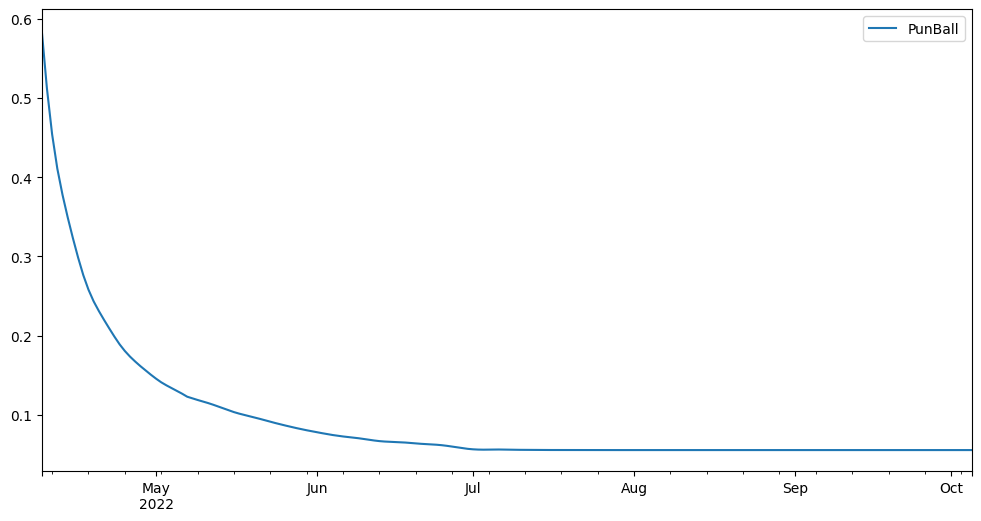

In [ ]:
PunBall=ret_unif[['PunBall']]

PunBall=PunBall.append(pd.DataFrame(forecasts_holt_pun,columns=['PunBall']))
PunBall.plot( y='PunBall', figsize=(12,6))

In [ ]:
analysis_pun = PunBall.copy()

decompose_result_mult_pun = seasonal_decompose(analysis_pun, model="multiplicative",two_sided=True,extrapolate_trend=3)

trend_pun = decompose_result_mult_pun.trend
seasonal_pun = decompose_result_mult_pun.seasonal
residual_pun = decompose_result_mult_pun.resid


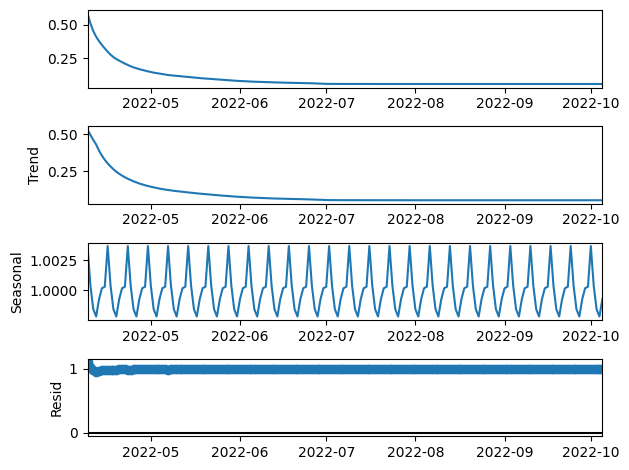

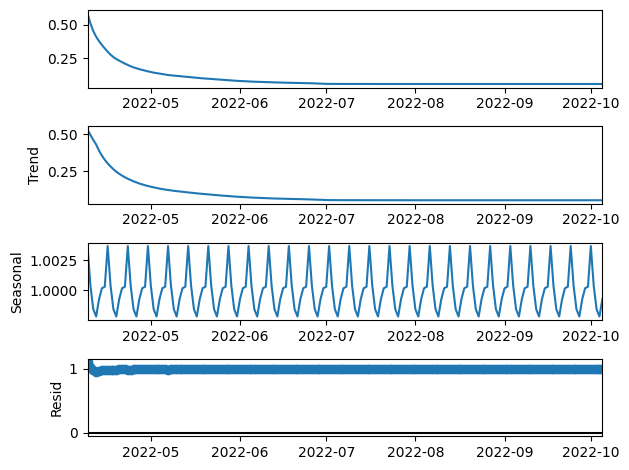

In [ ]:
decompose_result_mult_pun.plot()

In [ ]:
with open('csv','w') as f:
  f.write(pd.concat([trend_pun,seasonal_pun],axis=1).to_csv())

# Retenton Calculation

In [ ]:
#define GO URL

ret_go_url='https://api.sensortower.com/v1/android/usage/retention?app_ids=com.habby.punball,com.habby.archero\
&date_granularity=all_time&start_date=2021-01-01&end_date=2021-04-01&auth_token=yourtoken'


#define iOS URL

ret_ios_url='https://api.sensortower.com/v1/ios/usage/retention?app_ids=1453651052,1585781366&date_granularity=all_time\
&start_date=2021-01-01&end_date=2021-04-01&auth_token=yourtoken'

In [ ]:
#requesting go data
response_API_go = requests.get(ret_go_url)

#requesting ios data
response_API_ios = requests.get(ret_ios_url)

In [ ]:
#test API connection (code 200 means connection is OK)
print(response_API_go.status_code)

200


In [ ]:
#test API connection (code 200 means connection is OK)
print(response_API_ios.status_code)

200


In [ ]:
#get data
content = json.loads(response_API_go.content)

df_prov = pd.DataFrame.from_dict(content['app_data'])
ret=df_prov.loc[:,'corrected_retention']

ret_go=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
ret_go.columns = list(df_prov['app_id'])

ret_go.columns = ['Archero', 'PunBall']

ret_go

,Archero,PunBall
0,0.587719,0.585327
1,0.493640,0.513243
2,0.420782,0.455719
3,0.366968,0.412066
4,0.327380,0.378302
...,...,...
85,0.044583,0.056924
86,0.043963,0.057151
87,0.043339,0.057447
88,0.042810,0.057638


In [ ]:
#get data
content = json.loads(response_API_ios.content)

df_prov = pd.DataFrame.from_dict(content['app_data'])
ret=df_prov.loc[:,'corrected_retention']

ret_ios=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
ret_ios.columns = list(df_prov['app_id'])

ret_ios.columns = ['Archero', 'PunBall']

ret_ios

,Archero,PunBall
0,0.603849,0.586637
1,0.514448,0.509625
2,0.443469,0.450776
3,0.389576,0.408265
4,0.349022,0.376866
...,...,...
85,0.050443,0.054296
86,0.049877,0.053986
87,0.049290,0.053675
88,0.048752,0.053365


In [ ]:
#iOS and Android Mixture


# initialize list of lists
data = [['Archero', 0.522, 0.478, 0.611], ['PunBall', 0.699, 0.301, 0.389]]

# Create the pandas DataFrame
mixture = pd.DataFrame(data, columns=['Game', 'Android','iOS', 'Total'])


mixture




,Game,Android,iOS,Total
0,Archero,0.522,0.478,0.611
1,PunBall,0.699,0.301,0.389


In [ ]:
mixture.iloc[0,2]

0.478

In [ ]:
#Unified retention Go

ret_unif=pd.DataFrame(columns=['Total_Retention'])


ret_unif['Total_Retention']=(ret_go['Archero']*mixture.iloc[0,1]+ret_ios['Archero']*mixture.iloc[0,2])*mixture.iloc[0,3]+ (ret_go['PunBall']*mixture.iloc[1,1]+ret_ios['PunBall']*mixture.iloc[1,2])*mixture.iloc[1,3]

ret_unif

,Total_Retention
0,0.591653
1,0.506919
2,0.440420
3,0.390669
4,0.353341
...,...
85,0.050787
86,0.050450
87,0.050123
88,0.049813




# Bayesian Estimation of Exponential Decay's paramers for Retention Curve

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as arv
import pytensor as pyt

In [ ]:
def fn_μ_t(θ_t, μ_previous):
    μ = μ_previous*pm.math.exp(-θ_t)
    return μ

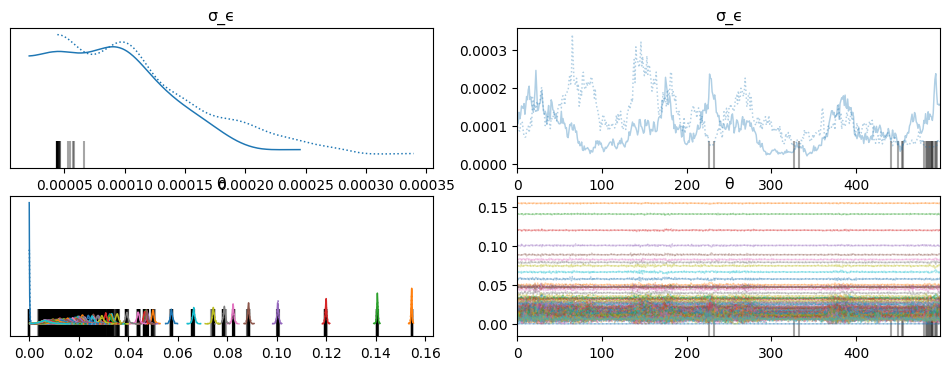

In [ ]:
y = ret_unif.iloc[:,0]

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)

    trace = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace);

In [ ]:
trace_summary = arv.summary(trace)
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ_ϵ,0.000,0.000,0.000,0.000,0.0,0.0,11.0,24.0,1.18
θ[0],0.000,0.000,0.000,0.000,0.0,0.0,68.0,325.0,1.04
θ[1],0.154,0.000,0.154,0.155,0.0,0.0,510.0,220.0,1.02
θ[2],0.141,0.000,0.140,0.141,0.0,0.0,1159.0,409.0,1.03
θ[3],0.120,0.000,0.119,0.121,0.0,0.0,1393.0,375.0,1.04
...,...,...,...,...,...,...,...,...,...
θ[85],0.007,0.003,0.002,0.012,0.0,0.0,694.0,234.0,1.03
θ[86],0.007,0.003,0.001,0.011,0.0,0.0,744.0,333.0,1.04
θ[87],0.007,0.003,0.001,0.011,0.0,0.0,1066.0,339.0,1.03
θ[88],0.006,0.003,0.001,0.011,0.0,0.0,864.0,349.0,1.02


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
trace_summary.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_unified"+'.csv', index =False)

# Retenton Tiers Calculation

In [ ]:
country=np.array(["US", "AU", "FR", "DE", "GB", "IT", "CA", "KR", "JP", "BR", "IN", "ES"])


In [ ]:

ret_go_df = []

for x in country:
  ret_go_url='https://api.sensortower.com/v1/android/usage/retention?app_ids=com.habby.punball,com.habby.archero\
  ,&date_granularity=all_time&start_date=2021-01-01&end_date=2021-04-01&country='+x+'&auth_token=yourtoken'

  response_API_go = requests.get(ret_go_url)
  content = json.loads(response_API_go.content)

  df_prov = pd.DataFrame.from_dict(content['app_data'])
  ret=df_prov.loc[:,'corrected_retention']

  ret_go=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
  ret_go.columns = list(df_prov['app_id'])

  ret_go.columns = ['Archero', 'PunBall']

  ret_go['Country']=df_prov.loc[0,'country']

  ret_go['Day']=range(90)

  ret_go_df.append(ret_go)

# see pd.concat documentation for more info
ret_go_df = pd.concat(ret_go_df)

In [ ]:

ret_go_df

,Archero,PunBall,Country,Day
0,0.541016,0.481089,US,0
1,0.466811,0.431585,US,1
2,0.406675,0.390232,US,2
3,0.359803,0.357173,US,3
4,0.323585,0.330844,US,4
...,...,...,...,...
85,0.048556,0.059326,ES,85
86,0.048267,0.058659,ES,86
87,0.048005,0.057992,ES,87
88,0.047743,0.057325,ES,88


In [ ]:
tier_1_go=ret_go_df.query("Country == 'US' | Country == 'CA' | Country == 'GB'| Country == 'AU' | Country == 'DE' | Country == 'FR'")

tier_2_go=ret_go_df.query("Country == 'JP' | Country == 'KR' | Country == 'ES'")

tier_3_go=ret_go_df.query("Country == 'BR' | Country == 'IN'")

In [ ]:
tier_1_go=tier_1_go.groupby('Day')['Archero', 'PunBall'].mean()
tier_2_go=tier_2_go.groupby('Day')['Archero', 'PunBall'].mean()
tier_3_go=tier_3_go.groupby('Day')['Archero', 'PunBall'].mean()

<ipython-input-7-05f605a53633>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_1_go=tier_1_go.groupby('Day')['Archero', 'PunBall'].mean()
<ipython-input-7-05f605a53633>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_2_go=tier_2_go.groupby('Day')['Archero', 'PunBall'].mean()
<ipython-input-7-05f605a53633>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_3_go=tier_3_go.groupby('Day')['Archero', 'PunBall'].mean()


In [ ]:
ret_ios_df = []

for x in country:
  ret_ios_url='https://api.sensortower.com/v1/ios/usage/retention?app_ids=1453651052,1585781366&date_granularity=all_time&start_date=2021-01-01\
  &end_date=2021-04-01&country='+x+'&auth_token=yourtoken'

  response_API_ios = requests.get(ret_ios_url)
  content = json.loads(response_API_ios.content)

  df_prov = pd.DataFrame.from_dict(content['app_data'])
  ret=df_prov.loc[:,'corrected_retention']

  ret_ios=pd.DataFrame.from_dict(dict(zip(ret.index, ret.values)))
  ret_ios.columns = list(df_prov['app_id'])

  ret_ios.columns = ['Archero', 'PunBall']

  ret_ios['Country']=df_prov.loc[0,'country']

  ret_ios['Day']=range(90)

  ret_ios_df.append(ret_ios)


# see pd.concat documentation for more info
ret_ios_df = pd.concat(ret_ios_df)

In [ ]:
ret_ios_df

,Archero,PunBall,Country,Day
0,0.561830,0.498201,US,0
1,0.488026,0.443082,US,1
2,0.427331,0.397179,US,2
3,0.379208,0.360559,US,3
4,0.341514,0.331675,US,4
...,...,...,...,...
85,0.060497,0.058496,ES,85
86,0.060136,0.057846,ES,86
87,0.059796,0.057197,ES,87
88,0.059457,0.056547,ES,88


In [ ]:
tier_1_ios=ret_ios_df.query("Country == 'US' | Country == 'CA' | Country == 'GB'| Country == 'AU' | Country == 'DE' | Country == 'FR'")

tier_2_ios=ret_ios_df.query("Country == 'JP' | Country == 'KR' | Country == 'ES'")

tier_3_ios=ret_ios_df.query("Country == 'BR' | Country == 'IN'")

In [ ]:
tier_1_ios=tier_1_ios.groupby('Day')['Archero', 'PunBall'].mean()
tier_2_ios=tier_2_ios.groupby('Day')['Archero', 'PunBall'].mean()
tier_3_ios=tier_3_ios.groupby('Day')['Archero', 'PunBall'].mean()

<ipython-input-7-4b76c49a01b8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_1_ios=tier_1_ios.groupby('Day')['Archero', 'PunBall'].mean()
<ipython-input-7-4b76c49a01b8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_2_ios=tier_2_ios.groupby('Day')['Archero', 'PunBall'].mean()
<ipython-input-7-4b76c49a01b8>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tier_3_ios=tier_3_ios.groupby('Day')['Archero', 'PunBall'].mean()


In [ ]:
tier_3_ios

,Archero,PunBall
Day,,
0,0.548089,0.541640
1,0.475535,0.477160
2,0.417316,0.424250
3,0.372538,0.382694
4,0.338731,0.350166
...,...,...
85,0.045824,0.057783
86,0.045485,0.056969
87,0.045166,0.056178


In [ ]:
#Archero and PunBall Mixture


# initialize list of lists
data = [['Archero',0.611169248], ['PunBall', 0.388830752]]

# Create the pandas DataFrame
mixture = pd.DataFrame(data, columns=['Game', 'Pct'])


mixture

,Game,Pct
0,Archero,0.611169
1,PunBall,0.388831


In [ ]:
tier_1_go

,Archero,PunBall
Day,,
0,0.549712,0.493545
1,0.472623,0.444737
2,0.411121,0.404742
3,0.364150,0.373349
4,0.328534,0.348194
...,...,...
85,0.045542,0.044102
86,0.045247,0.043662
87,0.044955,0.043224


In [ ]:
#Unified retention Go

ret_unif_go_tier1=pd.DataFrame(columns=['Total_Retention'])

ret_unif_go_tier2=pd.DataFrame(columns=['Total_Retention'])

ret_unif_go_tier3=pd.DataFrame(columns=['Total_Retention'])


ret_unif_go_tier1['Total_Retention']=tier_1_go['Archero']*mixture.iloc[0,1]+tier_1_go['PunBall']*mixture.iloc[1,1]

ret_unif_go_tier2['Total_Retention']=tier_2_go['Archero']*mixture.iloc[0,1]+tier_2_go['PunBall']*mixture.iloc[1,1]

ret_unif_go_tier3['Total_Retention']=tier_3_go['Archero']*mixture.iloc[0,1]+tier_3_go['PunBall']*mixture.iloc[1,1]



In [ ]:
#Unified retention ios

ret_unif_ios_tier1=pd.DataFrame(columns=['Total_Retention'])

ret_unif_ios_tier2=pd.DataFrame(columns=['Total_Retention'])

ret_unif_ios_tier3=pd.DataFrame(columns=['Total_Retention'])


ret_unif_ios_tier1['Total_Retention']=tier_1_ios['Archero']*mixture.iloc[0,1]+tier_1_ios['PunBall']*mixture.iloc[1,1]

ret_unif_ios_tier2['Total_Retention']=tier_2_ios['Archero']*mixture.iloc[0,1]+tier_2_ios['PunBall']*mixture.iloc[1,1]

ret_unif_ios_tier3['Total_Retention']=tier_3_ios['Archero']*mixture.iloc[0,1]+tier_3_ios['PunBall']*mixture.iloc[1,1]

In [ ]:
#
ret_unif['Day']=pd.date_range('2022-04-09', periods=90, freq='D')

ret_unif.set_index('Day', inplace=True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt


#https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861



# Bayesian Estimation of Exponential Decay's paramers for Retention Curve

In [ ]:
!pip install Pytensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as arv
import pytensor as pyt

In [ ]:
print(pm.__version__)

5.1.2


In [ ]:
def fn_μ_t(θ_t, μ_previous):
    μ = μ_previous*pm.math.exp(-θ_t)
    return μ

## Tier 1 google

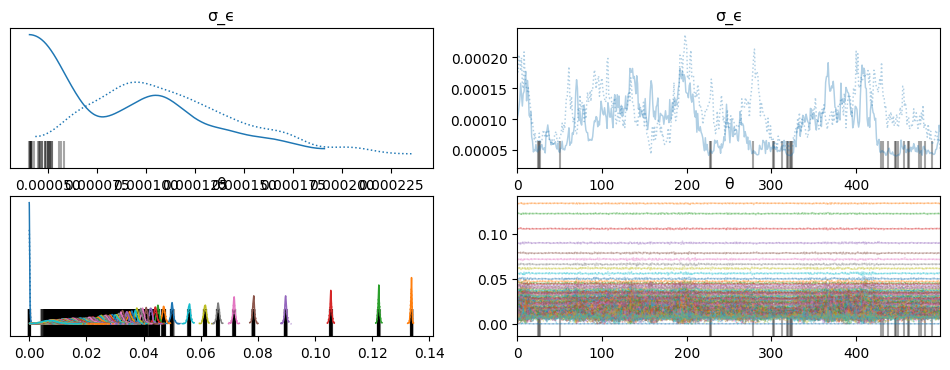

In [ ]:
y = ret_unif_go_tier1.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace);

In [ ]:
trace_summary = arv.summary(trace)
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ_ϵ,0.000,0.000,0.000,0.000,0.0,0.0,26.0,53.0,1.11
θ[0],0.000,0.000,0.000,0.000,0.0,0.0,162.0,375.0,1.01
θ[1],0.134,0.000,0.133,0.134,0.0,0.0,739.0,675.0,1.00
θ[2],0.122,0.000,0.122,0.123,0.0,0.0,1600.0,745.0,1.02
θ[3],0.105,0.000,0.105,0.106,0.0,0.0,1303.0,581.0,1.02
...,...,...,...,...,...,...,...,...,...
θ[85],0.008,0.003,0.000,0.013,0.0,0.0,986.0,287.0,1.01
θ[86],0.008,0.003,0.002,0.014,0.0,0.0,1252.0,530.0,1.01
θ[87],0.008,0.003,0.002,0.014,0.0,0.0,682.0,247.0,1.01
θ[88],0.008,0.003,0.001,0.013,0.0,0.0,634.0,484.0,1.01


In [ ]:
#type(trace_summary)

with open('csv','w') as f:
  f.write(trace_summary.to_csv())

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
trace_summary.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_go_1"+'.csv', index =False)

## Tier 2 google

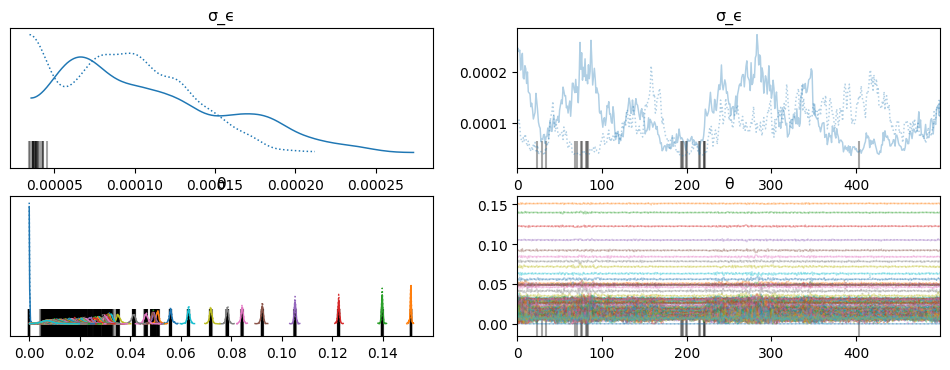

In [ ]:
y = ret_unif_go_tier2.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace_go_2 = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace_go_2);

In [ ]:
trace_summary_go_2 = arv.summary(trace_go_2)

In [ ]:
trace_summary_go_2.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_go_2"+'.csv', index =False)

## Tier 3 google

In [ ]:
y = ret_unif_go_tier3.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace_go_3 = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace_go_3);

NameError: ignored

In [ ]:
trace_summary_go_3 = arv.summary(trace_go_3)

NameError: ignored

In [ ]:
trace_summary_go_3.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_go_3"+'.csv', index =False)

## Tier 1 iOS

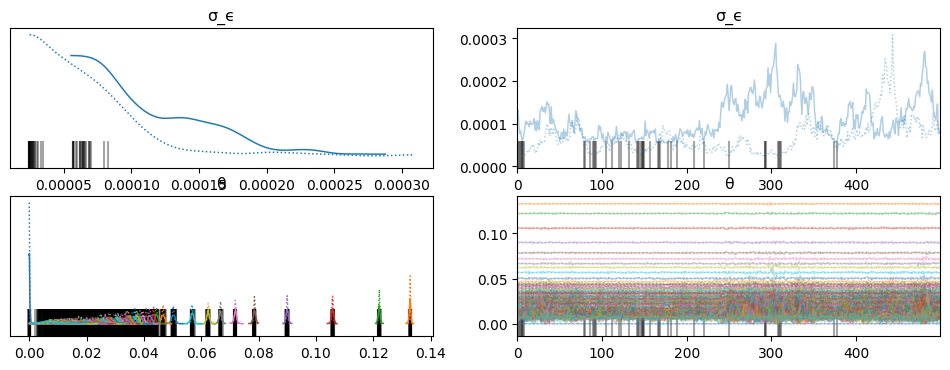

In [ ]:
y = ret_unif_ios_tier1.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace_ios_1 = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace_ios_1);

In [ ]:
trace_summary_ios_1 = arv.summary(trace_ios_1)

In [ ]:
trace_summary_ios_1.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_ios_1"+'.csv', index =False)

## Tier 2 iOS

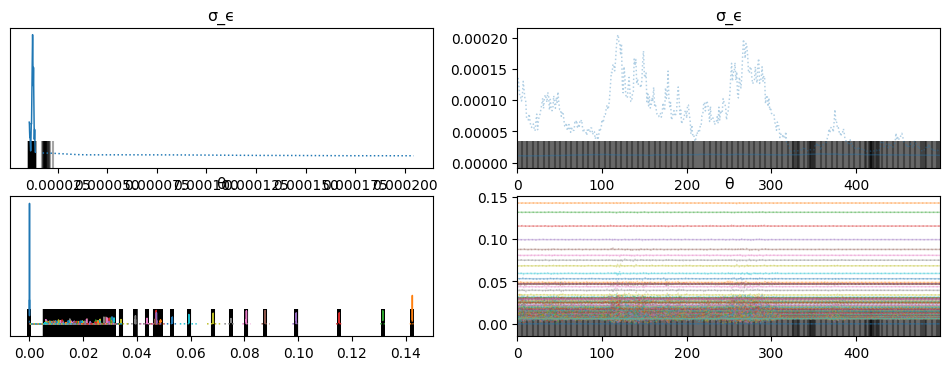

In [ ]:
y = ret_unif_ios_tier2.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace_ios_2 = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace_ios_2);

In [ ]:
trace_summary_ios_2 = arv.summary(trace_ios_2)

In [ ]:
trace_summary_ios_2.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_ios_2"+'.csv', index =False)

## Tier 3 iOS

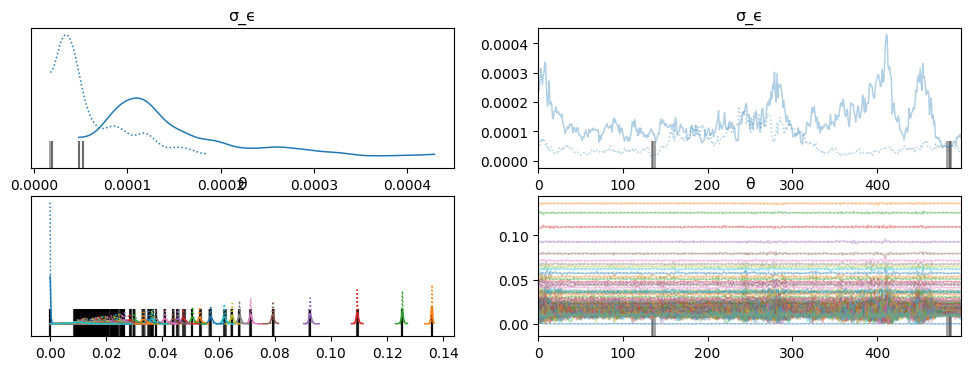

In [ ]:
y = ret_unif_ios_tier3.iloc[:,0] #np.array([0.491700486,	0.359814429,	0.273621994,	0.219318285,	0.184230865,	0.159618344,	0.141096513,	0.126114328,	0.114070134,	0.104278939])

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    θ=pm.Uniform("θ", 0, 1, shape=len(y))
    #θ = pm.Uniform('θ', 0,1,, shape=len(y))
    #σ_ϵ = pm.HalfNormal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [θ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))

    #sigma=pm.Uniform("sigma", 0.1, pm.math.sqrt(μ * (1 - μ)))


    #level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    level = pm.Beta("level", mu = μ, sigma = σ_ϵ,observed =y)
    #pred = pm.MutableData("pred", y[89])
    trace_ios_3 = pm.sample(500,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace_ios_3);

In [ ]:
trace_summary_ios_3 = arv.summary(trace_ios_3)

In [ ]:
trace_summary_ios_3.to_csv('/drive/My Drive/Colab Notebooks/LTV_Ret_Decay_param_est/'+"trace_summary_ios_3"+'.csv', index =False)

## TESTING ⬇

In [ ]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
predictors_out_of_sample = y[89]

with m5:
    # update values of predictors:
    pm.set_data({"level": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        trace,
        var_names=["level"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

TypeError: ignored

In [ ]:
trace_summary = arv.summary(trace)

In [ ]:
with m5:
  post_pred = pm.sample_posterior_predictive(trace)

post_pred

#     ppc = pm.sample_posterior_predictive(trace)
# _, ax = plt.subplots(1,1,figsize=(12,5))

# ax.plot(range(90), ppc['level'].T[:,1:], alpha=0.03, color='b', label='_')
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 12*2))


# ax.plot(range(90),ppc['level'].T[:,1],alpha=0.03, color='b', label='Samples from our posterior distribution')
# ax.plot(y, color='darkorange', label='data')
# ax.legend();

Inference data with groups:
	> posterior_predictive
	> observed_data

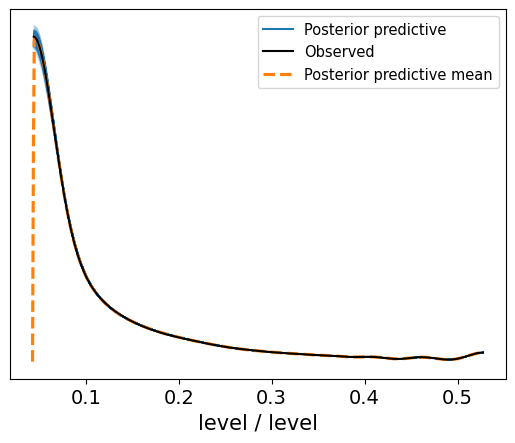

In [ ]:
with m5:
    ak=pm.sample_posterior_predictive(trace, extend_inferencedata=True)


arv.plot_ppc(trace, num_pp_samples=1000);



In [ ]:
y[89]

0.04361885198956267

In [ ]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

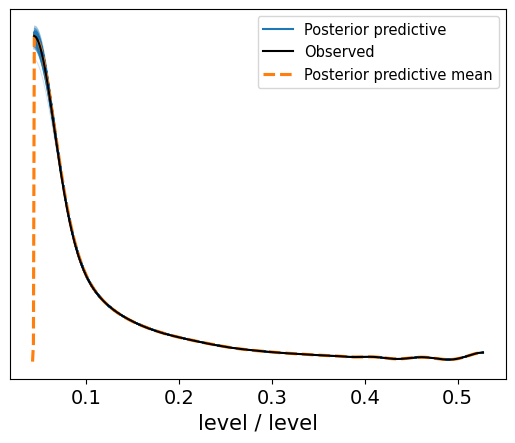

In [ ]:
trace_summary = arv.summary(trace)

with m5:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["level"], random_seed=42
    )
arv.plot_ppc(ppc_all, num_pp_samples=1000);

In [ ]:
# expanded_data = trace.posterior.expand_dims(pred_id=3)
# with m5:
#     trace.extend(pm.sample_posterior_predictive(
#         expanded_data, var_names=["level"], random_seed=42))


thinned_idata = trace.sel(draw=slice(y[89], None, None))

with m5:
    ppc_all=pm.sample_posterior_predictive(thinned_idata)

In [ ]:
ppc_all.to_dataframe().shape

(1998, 92)

In [ ]:
ppc_all.to_dataframe() #.shape #.iloc[1999,20:25]




,chain,draw,"(level[0], 0)","(level[10], 10)","(level[11], 11)","(level[12], 12)","(level[13], 13)","(level[14], 14)","(level[15], 15)","(level[16], 16)",...,"(level[82], 82)","(level[83], 83)","(level[84], 84)","(level[85], 85)","(level[86], 86)","(level[87], 87)","(level[88], 88)","(level[89], 89)","(level[8], 8)","(level[9], 9)"
0,0,1,0.527960,0.229026,0.218534,0.209093,0.199706,0.191708,0.183744,0.176780,...,0.046122,0.045767,0.045336,0.044933,0.044544,0.044396,0.043789,0.043695,0.254833,0.240701
1,0,2,0.527863,0.229087,0.218602,0.209085,0.199822,0.191528,0.183851,0.176767,...,0.046032,0.045798,0.045484,0.044814,0.044576,0.044358,0.044026,0.043716,0.254737,0.240817
2,0,3,0.528004,0.229064,0.218571,0.209058,0.199902,0.191575,0.183702,0.176859,...,0.046081,0.045841,0.045354,0.044863,0.044516,0.044344,0.043789,0.043659,0.254657,0.240676
3,0,4,0.527590,0.229168,0.218584,0.208962,0.199977,0.191426,0.183804,0.176568,...,0.046053,0.045655,0.045291,0.045160,0.044759,0.044166,0.044040,0.043605,0.254567,0.240922
4,0,5,0.527866,0.229230,0.218478,0.208970,0.200002,0.191559,0.183899,0.176992,...,0.046001,0.045688,0.045465,0.045110,0.044710,0.044455,0.043986,0.043587,0.254777,0.240764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,1,995,0.527843,0.229074,0.218497,0.208893,0.199920,0.191684,0.184145,0.176805,...,0.046121,0.045599,0.045452,0.044960,0.044443,0.044291,0.044218,0.043630,0.254574,0.240555
1994,1,996,0.527800,0.229034,0.218637,0.208810,0.200065,0.191649,0.184015,0.176956,...,0.046073,0.045598,0.045309,0.044931,0.044616,0.044085,0.043976,0.043533,0.254755,0.240668
1995,1,997,0.527906,0.229140,0.218244,0.209058,0.199726,0.191592,0.183928,0.176776,...,0.046167,0.045779,0.045230,0.044870,0.044697,0.044233,0.043973,0.043589,0.254720,0.240747
1996,1,998,0.527934,0.229021,0.218589,0.208817,0.199848,0.191637,0.183942,0.176773,...,0.046166,0.045624,0.045565,0.044987,0.044605,0.044154,0.044087,0.043523,0.254744,0.240774


In [ ]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
predictors_out_of_sample = y[89]

with m5:
    # update values of predictors:
    pm.set_data({"level": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        trace,
        var_names=["level"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

TypeError: ignored

# Random Walk testing

In [ ]:
aesara.config.compute_test_value = 'ignore'

def step(s, y, s_previous, α):
    s = α*y + (1-α)*s_previous
    return s

s = at.vector('s')
y = at.vector('y')
α = at.scalar('α')
i = at.scalar('i')

output, updates = aesara.scan(fn=step,
                              sequences=[s, y],
                              non_sequences=[α],
                              outputs_info=[i])

f = aesara.function(inputs=[s, y, α, i],
                    outputs=output,
                    updates=updates)

s = np.zeros(9).astype(aesara.config.floatX)
y = np.arange(9).astype(aesara.config.floatX)
α = 0.7
i = 0

print(f(s, y, α, i)[0:5])

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([iteration_1,
       iteration_2,
       iteration_3,
       iteration_4,
       iteration_5])

[0.     0.7    1.61   2.583  3.5749]
[0.0, 0.7, 1.6099999999999999, 2.5829999999999997, 3.5749]


In [ ]:
from decimal import Decimal

In [ ]:
s = np.zeros(9)
y = np.arange(0, 9)
α = Decimal('0.7')
i = 0

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([float(iteration_1),
       float(iteration_2),
       float(iteration_3),
       float(iteration_4),
       float(iteration_5)])

[0.0, 0.7, 1.61, 2.583, 3.5749]


In [ ]:
y = np.arange(0, 9)+0.12151

#pyt.config.floatX = 'float64'

def fn_μ_t(ξ_t, μ_previous):
    μ = μ_previous + ξ_t
    return μ


with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    smth_parm = pm.Uniform('alpha', 0,1)
    ξ = pm.Normal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = pyt.shared(y[0])

    μ, updates = pyt.scan(fn=fn_μ_t,
                                    sequences = [ξ],
                                    outputs_info = [μ_1],
                                    n_steps=len(y))
    level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)
arv.plot_trace(trace);

FutureWarning: ignored

array([[<Axes: title={'center': 'ξ'}>, <Axes: title={'center': 'ξ'}>],
       [<Axes: title={'center': 'σ_ϵ'}>, <Axes: title={'center': 'σ_ϵ'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

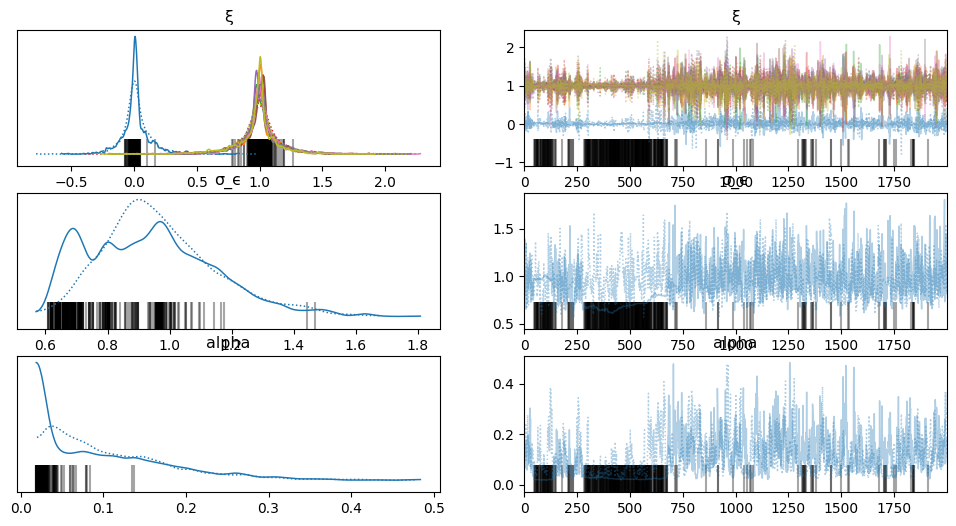

In [ ]:
arv.plot_trace(trace)

In [ ]:
y = np.arange(0, 9)+0.12151
y

array([0.12151, 1.12151, 2.12151, 3.12151, 4.12151, 5.12151, 6.12151,
       7.12151, 8.12151])